In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt 

from fase.core.common import HEAANContext

from fase import HEAAN as he

class Param():
    def __init__(self, n=None, logn=None, logp=None, logq=None, logQboot=None):
        self.n = n
        self.logn = logn
        self.logp = logp
        self.logq = logq 
        self.logQboot = logQboot
        if self.logn == None:
            self.logn = int(np.log2(n))

Using CPU version HEAAN


In [23]:
logq = 600
logp = 50
logn = 8
n = 1*2**logn
slots = n

parms = Param(n=n, logp=logp, logq=logq)

do_reduction=False


ring = he.Ring()
secretKey = he.SecretKey(ring)

scheme = he.Scheme(secretKey, ring, True)

print("Enc Key:", scheme._cpp_EncKeyName)
print("conj Key:", scheme._cpp_ConjKeyName)

algo = he.SchemeAlgo(scheme)

Enc Key:INIT1
 EncKey.txt
conj Key: ConjKey.txt


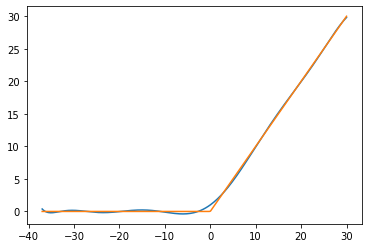

In [49]:
from numpy.polynomial import chebyshev

def sigmoid(x):
    return 1./(1.+np.exp(-x))

def ReLU(x):
    return x * (x > 0)

def _exp(x, a=1):
    return a*(np.exp(x)-1)

def ELU(x, a=1):
    return np.piecewise(x, [x<0, x>=0], [lambda x:_exp(x,a=a), lambda x:x])

def swish(x):
    return x * sigmoid(x)

xx = np.linspace(-37, 30, 256)
deg = 10
#apprx_swish = chebyshev.Chebyshev.fit(xx, swish(xx), deg=deg) # F.elu 64%
#apprx_elu = chebyshev.Chebyshev.fit(xx, ELU(xx), deg=deg) # F.elu
apprx_relu = chebyshev.Chebyshev.fit(xx, ReLU(xx), deg=deg) # 150 iterations, 63%

apprx = apprx_relu

plt.plot(xx, apprx(xx))
plt.plot(xx, ReLU(xx))

In [25]:
def encrypt(xx):
    # n = nslots
    vv = np.zeros(n)
    vv[:len(xx)] = xx
    ctxt = he.Ciphertext()
    scheme.encrypt(ctxt, he.Double(xx), n, logp, logq)
    return ctxt
    
def decrypt(ctxt):
    dd = scheme.decrypt(secretKey, ctxt)
    arr = np.zeros(ctxt.n, dtype=np.complex128)
    dd.__getarr__(arr)
    del dd
    return arr.real


### function poly 

If it works, it's the best case.

In [26]:
ctxt = encrypt(xx)

In [27]:
from numpy import polynomial as P

power = apprx_swish.convert(kind=P.Polynomial)

coeffs = power.coef

In [28]:
output = he.Ciphertext()
algo.function_poly(output, 
           ctxt, 
           he.Double(coeffs), 
           logp, 
           len(coeffs)-1)

In [29]:
output.logq # 390?

350

10


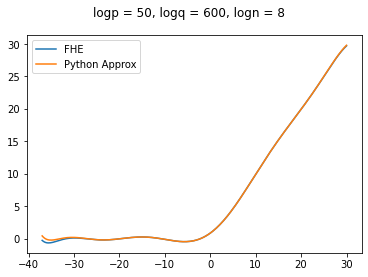

In [30]:
val = decrypt(output)

plt.plot(xx, val, label = "FHE")
plt.plot(xx, apprx_swish(xx), label="Python Approx")
plt.legend()
plt.suptitle(f"logp = {logp}, logq = {logq}, logn = {logn}")
plt.savefig(f"FHE_accuracy_deg-{deg}_{logq}_{logp}_{logn}.png")
print(deg)

#### logp를 올리는데 한계가 있다면.. 함수를 나누어서 계산
왜 나눠야하는 걸까...

In [31]:
output2 = he.Ciphertext()
algo.function_poly(output2, 
           output, 
           he.Double(coeffs), 
           logp, 
           len(coeffs)-1)

In [32]:
output2.logq

100

10


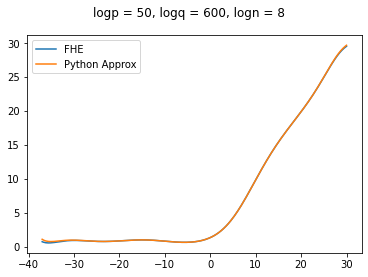

In [33]:
plt.plot(xx, decrypt(output2), label = "FHE")
plt.plot(xx, apprx_swish(apprx_swish(xx)), label="Python Approx")
plt.legend()
plt.suptitle(f"logp = {logp}, logq = {logq}, logn = {logn}")
plt.savefig(f"FHE_accuracy_deg-{deg}_{logq}_{logp}_{logn}_xx2.png")
print(deg)

In [ ]:
plt.plot(xx, decrypt(output2), label = "FHE")
plt.plot(xx, apprx_swish(apprx_swish(xx)), label="Python Approx")
plt.legend()
plt.suptitle(f"logp = {logp}, logq = {logq}, logn = {logn}")
plt.savefig(f"FHE_accuracy_deg-{deg}_{logq}_{logp}_{logn}_xx2.png")
print(deg)

In [36]:
yy = apprx_swish(apprx_swish(xx))

In [101]:
xx = np.linspace(-37, 30, 512)
deg = 9
#apprx_swish = chebyshev.Chebyshev.fit(xx, swish(xx), deg=deg) # F.elu 64%
#apprx_elu = chebyshev.Chebyshev.fit(xx, ELU(xx), deg=deg) # F.elu
apprx7 = chebyshev.Chebyshev.fit(xx, ReLU(xx-0.1), deg=8) # 150 iterations, 63%
apprx8 = chebyshev.Chebyshev.fit(xx, ReLU(xx), deg=8) # 150 iterations, 63%
apprx9 = chebyshev.Chebyshev.fit(xx, ReLU(xx+0.1), deg=8) # 150 iterations, 63%

#apprx = apprx_relu

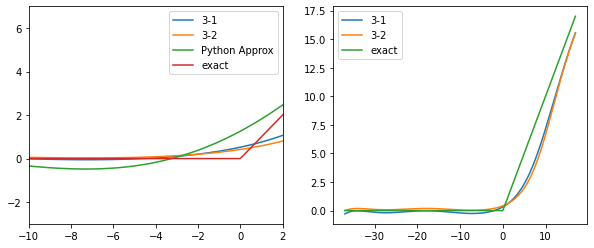

In [131]:
xx2 = np.linspace(-37, 17, 512)

fig, axs = plt.subplots(1,2, figsize=(10,4))
#axs[0].plot(xx2, apprx7(apprx8(apprx9(xx2))), label="3")
axs[0].plot(xx2, apprx8(apprx8(apprx8(xx2)))-1.8, label="3-1")
axs[0].plot(xx2, apprx8(apprx8(apprx8(apprx8(xx2))))-2.2, label="3-2")
#axs[0].plot(xx2, apprx8(apprx9(xx2)), label="Python Approx2")
axs[0].plot(xx2, apprx9(xx2), label="Python Approx")
axs[0].plot(xx2, ReLU(xx2), label="exact")
axs[0].legend()
axs[0].set_xlim([-10,2])
axs[0].set_ylim([-3,7])

#axs[1].plot(xx2, apprx7(apprx8(apprx9(xx2))), label="3")
axs[1].plot(xx2, apprx8(apprx8(apprx8(xx2)))-2, label="3-1")
axs[1].plot(xx2, apprx8(apprx8(apprx8(apprx8(xx2))))-2.2, label="3-2")
#axs[1].plot(xx2, apprx8(apprx9(xx2)), label="Python Approx2")
#axs[1].plot(xx2, apprx9(xx2), label="Python Approx")
axs[1].plot(xx2, ReLU(xx2), label="exact")
axs[1].legend()


plt.show()

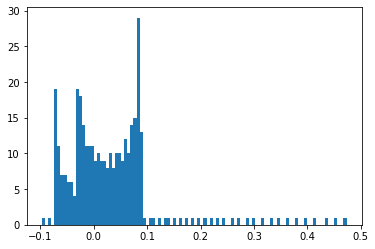

In [144]:
plt.hist(apprx8(apprx8(apprx8(apprx8(xx2[xx2 < 1]))))-2.3, bins=100)
plt.show()

In [ ]:
x1 = np.linspace(-37, 0, 512)
plt.plot(x1, apprx8(apprx8(apprx8(apprx8(x1))))-2, label="3-2")

### HEAANContext... 

In [ ]:
ckks_he = HEAANContext(5, 30, 150, boot=True)